# Using Xiaobiao pre-process output of the global model this script subsample to the region
- done as a first step to setup the model
- everything is now performed from raw data in `seeding-mpw.ipynb` and `seeding-uniform.ipynb`.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import path, colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import urllib.request
import skimage.io as io
import os
from os.path import join
from datetime import datetime
import scipy as sc
from scipy import stats
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
import shapely
import cartopy.io.shapereader as shpreader
import cmocean
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [2]:
!pwd

/nexsan/people/pmiron/projects_mars/caribbean-marine-litter/notebooks


## Coasts

In [3]:
folder = '../data/raw/temp/'

csv_files = [join(folder, 'coasts_all_x.csv'),
             join(folder, 'coasts_all_y.csv'),
             join(folder, 'coasts_all_w.csv')]

df_c = pd.concat([pd.read_csv(file, header=None) for file in csv_files], axis=1)
df_c.columns = ['longitude', 'latitude', 'weight [ton]']
df_c['source [0:land, 1:river]'] = np.zeros(len(df_c), dtype='int')

In [4]:
df_c

,longitude,latitude,weight [ton],"source [0:land, 1:river]"
0,-175.4962,-21.2593,11.9819,0
1,-175.5369,-21.0527,26.5777,0
2,-174.8840,-21.1788,57.7232,0
3,-175.0601,-20.9595,14.0919,0
4,-174.8540,-21.2223,13.5319,0
...,...,...,...,...
28708,120.3880,14.2541,1355.4000,0
28709,120.4254,14.2711,1355.4000,0
28710,120.4208,14.2703,1355.4000,0
28711,120.3807,14.2136,1355.4000,0


## Rivers

In [5]:
csv_files = [join(folder, 'rivers_all_x.csv'),
             join(folder, 'rivers_all_y.csv'),
             join(folder, 'rivers_all_w.csv')]

df_r = pd.concat([pd.read_csv(file, header=None) for file in csv_files], axis=1)
df_r.columns = ['longitude', 'latitude', 'weight [ton]']
df_r['source [0:land, 1:river]'] = np.ones(len(df_r), dtype='int')

In [6]:
df_r

,longitude,latitude,weight [ton],"source [0:land, 1:river]"
0,3.8659,37.1401,12.7833,1
1,5.9465,37.0161,35.0865,1
2,7.8943,37.1285,12.4245,1
3,3.6030,37.0258,28.7290,1
4,3.1497,37.0693,12.5625,1
...,...,...,...,...
3582,91.3428,22.2389,1425.4600,1
3583,91.3840,22.2174,1425.4600,1
3584,91.3574,22.2282,1425.4600,1
3585,91.3282,22.2190,1425.4600,1


In [7]:
# the country ids are based on gadm36_levels_shp country files
csv_file = join(folder, 'country_reference_list.csv')
df_country_ref = pd.read_csv(csv_file, header=None)
df_country_ref.columns = ['country id', 'country']

In [8]:
df_country_ref.head()

,country id,country
0,1,Aruba
1,2,Afghanistan
2,3,Angola
3,4,Anguilla
4,5,Åland


In [9]:
# country associated with particles
csv_file = join(folder, 'dist_closest_country.csv')
df_cc = pd.read_csv(csv_file, header=None)
df_cc.columns = ['country id', 'distance to coast [km]']
df_cc['country'] = df_country_ref['country'].values[df_cc['country id'] - 1]
df_cc = df_cc[['country', 'country id', 'distance to coast [km]']]

In [10]:
df_cc

,country,country id,distance to coast [km]
0,Tonga,224,19.9970
1,Tonga,224,19.2040
2,Tonga,224,11.4470
3,Tonga,224,11.9910
4,Tonga,224,9.2293
...,...,...,...
32295,Bangladesh,23,15.6390
32296,Bangladesh,23,20.1180
32297,Bangladesh,23,17.2440
32298,Bangladesh,23,14.4360


In [11]:
# save global initial release to one csv
df = pd.concat((df_c, df_r), axis=0)
df = pd.concat((df.reset_index(drop=True), df_cc.reset_index(drop=True)), axis=1)
df.to_csv(join(folder, 'initial-locations-global.csv'), index=False)

In [12]:
df

,longitude,latitude,weight [ton],"source [0:land, 1:river]",country,country id,distance to coast [km]
0,-175.4962,-21.2593,11.9819,0,Tonga,224,19.9970
1,-175.5369,-21.0527,26.5777,0,Tonga,224,19.2040
2,-174.8840,-21.1788,57.7232,0,Tonga,224,11.4470
3,-175.0601,-20.9595,14.0919,0,Tonga,224,11.9910
4,-174.8540,-21.2223,13.5319,0,Tonga,224,9.2293
...,...,...,...,...,...,...,...
32295,91.3428,22.2389,1425.4600,1,Bangladesh,23,15.6390
32296,91.3840,22.2174,1425.4600,1,Bangladesh,23,20.1180
32297,91.3574,22.2282,1425.4600,1,Bangladesh,23,17.2440
32298,91.3282,22.2190,1425.4600,1,Bangladesh,23,14.4360


## Subset in the Caribbean

In [13]:
def particles_caribbean(x, y, xc, yc):
    """
    Retrieve coordinates (x,y) located inside a contour defined by (xc, yc)

    Args:
        x: longitude of coordinates
        y: latitude of coordinates
        xc: latitude of the contour
        yc: longitude of the contour
        
    Return:
        logical arrays len(x)
    """
    p = path.Path(np.column_stack((xc, yc)))
    return p.contains_points(np.column_stack((x, y)))

xc = np.array([-51.6, -76.8, -78, -79.3, -81, -82.7, -87.3, -98.5, -98.5, -66.7, -51, -51.6])
yc = np.array([3.9, 7, 8.6, 9.2, 8.2, 8.8, 14.8, 19.0, 31.0, 31.0, 31.0, 3.9])

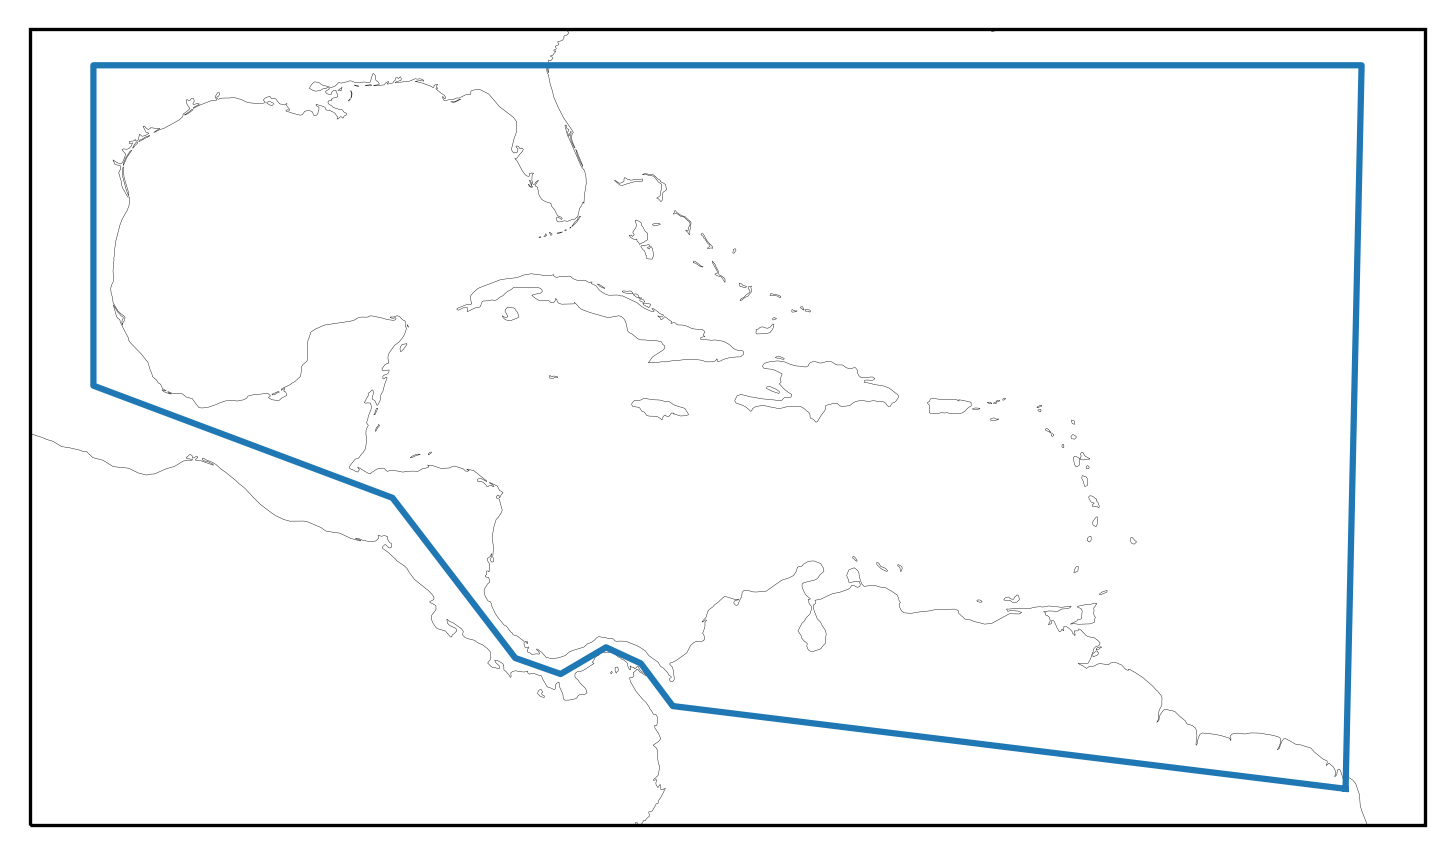

In [17]:
# uniform mpw in the region
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())

ax.plot(xc, yc, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

In [15]:
print(f'domain [{min(xc)}, {max(xc)}] x [{min(yc)}, {max(yc)}]')

domain [-98.5, -51.0] x [3.9, 31.0]


In [15]:
output_folder = '../data/process/subset_release_locations'

# save coasts and rivers subsets
in_region = particles_caribbean(df.longitude, df.latitude, xc, yc)

df_subset = df.loc[np.logical_and(df['source [0:land, 1:river]'] == 0, in_region)]
df_subset.to_csv(join(output_folder, 'coasts.csv'), index=False)

df_subset_r = df.loc[np.logical_and(df['source [0:land, 1:river]'] == 1, in_region)]
df_subset_r.to_csv(join(output_folder, 'rivers.csv'), index=False)

## input from the boundary

In [16]:
start_date = datetime(2010, 1, 1)
end_date = datetime(2010, 10, 1)

df_bnd = pd.read_csv(join(output_folder, 'inputs.csv'), parse_dates=['date'])
df_bnd = df_bnd.loc[np.logical_and(df_bnd['date'] >= start_date, df_bnd['date'] < end_date)]

## Plot in the region

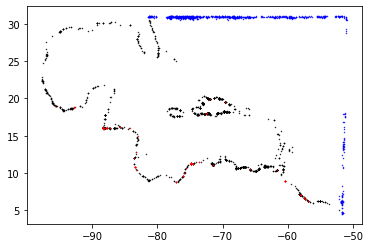

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(df_subset.longitude, df_subset.latitude, s=0.2, color='k')
ax.scatter(df_subset_r.longitude, df_subset_r.latitude, s=0.2, color='r')
ax.scatter(df_bnd.longitude, df_bnd.latitude, s=0.2, color='b')